# All try code

In [31]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from os import listdir
from mne.channels import make_standard_montage
from scipy import signal
from scipy.linalg import sqrtm, inv 

def GetRawEDF(target_subjects= "all", condition="offline"):

    EEG_data = {}

    if condition == "offline":
        condition = "Offline_Experiment"
    elif condition == "online":
        condition = "Online_Experiment"

    if target_subjects == "all":
        target_subjects = ["pipo","NutF8","AJpang","Aoomim","voen"]

    for i in range (0,len(target_subjects)):

        path = "C:\\git\Senior_Thesis\\DataSet\\"+condition+"\\"+ target_subjects[i] +"\\notch_EDF\\"
        list_dir = listdir(path)
        raw_each = [0] * len(list_dir)
        for j in range(len(list_dir)):
            raw_each[j] = mne.io.read_raw_edf(path+list_dir[j],preload = False)
            
        raw_edf = mne.concatenate_raws(raw_each)

        eegbci.standardize(raw_edf)  # set channel names
        montage = make_standard_montage("standard_1005")
        raw_edf.set_montage(montage)

        EEG_data[target_subjects[i]] = {"Raw_data": raw_edf.copy()}

    print(f"Successful to create Data of {target_subjects}")

    return EEG_data

EEG_data = GetRawEDF(target_subjects = "all")

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Offline_Experiment\pipo\notch_EDF\sess1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Offline_Experiment\pipo\notch_EDF\sess2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Offline_Experiment\pipo\notch_EDF\sess3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Offline_Experiment\NutF8\notch_EDF\sess1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Offline_Experiment\NutF8\notch_EDF\sess2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\git\Senior_The

In [22]:
target_sub = ["pipo","nutF8","AJpang","Aoomim"]

a = [0,0,0,0]

EEG_data = {}

for i in target_sub:
    EEG_data[i] = {"Raw_data": a.copy()}

nor = [5,5,5]

for key in EEG_data:
    print(key)
    EEG_data[key]["EA_data"] = nor


# for sub_key in EEG_data:
#     for data_key in EEG_data[sub_key]:
#         print(sub_key,data_key)
    


pipo
nutF8
AJpang
Aoomim


In [19]:
EEG_data

{'pipo': {'data': [0, 0, 0, 0], 'EA_data': [5, 5, 5]},
 'nutF8': {'data': [0, 0, 0, 0], 'EA_data': [5, 5, 5]},
 'AJpang': {'data': [0, 0, 0, 0], 'EA_data': [5, 5, 5]},
 'Aoomim': {'data': [0, 0, 0, 0], 'EA_data': [5, 5, 5]}}

# Try CSP with multiple subjects

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict, KFold

def computeCSPFeatures(data, target_subjects,condition):

    all_data = None
    label = None

    if condition == "noEA":
        query = "Raw_Epoch"
    else:
        query = "EA_Epoch"

    for sub in target_subjects:
        if all_data is None:
            all_data = data[sub]['Raw_Epoch']
        else:
            all_data = np.concatenate((all_data, data[sub][query]), axis=0)

        if label is None:
            label = data[sub]['label']
        else:
            label = np.concatenate((label, data[sub]['label']), axis=0)


    print(np.array(all_data).shape, np.array(label).shape)
    
    csp = CSP(n_components=8, reg=None, log=None, rank= 'info')

    train_data_csp, label = shuffle(all_data, label, random_state = 0)
    X_train, X_test, y_train, y_test = train_test_split(train_data_csp, label, test_size= 0.3, random_state = 0, stratify=label)
    csp.fit(X_train, y_train)

    X_train = csp.transform(X_train)
    X_test  = csp.transform(X_test)


    lda = LinearDiscriminantAnalysis()
    score = cross_val_score(lda, X_train, y_train, cv= 10)
    print("LDA only Cross-validation scores:", np.mean(score))
    lda.fit(X_train, y_train)
        
    from sklearn.metrics import classification_report,confusion_matrix

    y_pred = lda.predict(X_train)

    print("Classification TRAIN DATA \n=======================")
    print(classification_report(y_true=y_train, y_pred=y_pred))
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true=y_train, y_pred=y_pred))

    y_pred = lda.predict(X_test)

    print("Classification TEST DATA \n=======================")
    print(classification_report(y_true=y_test, y_pred=y_pred))
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))

computeCSPFeatures(EEG_Epochs, target_subjects = ["pipo","voen","AJpang"] ,condition = "noEA")

# Backup

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class LogReg_TL(BaseEstimator):

    def __init__(self, learningRate=1e-5, num_iter=100, penalty=None, intercept = True,\
                 lambd=1, Sigma_TL=np.array([[0, 0],[0, 0]]), mu=0):
        
        self.learningRate = learningRate
        self.num_iter = num_iter
        self.penalty = penalty
        self.intercept = intercept
        self.Sigma_TL = Sigma_TL
        self.lambd = lambd
        self.mu = mu

    def __softmax(self,z): #Change from sigmoid to softmax for multi-classification
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def __reg_logLL1(self,z, y, weights): # cal sum of negative log-likelihood (2)
        reg = self.lambd * np.linalg.norm(weights)**2
        return (-1 * np.sum((y * np.log10(self.__softmax(z))) + ((1 - y) * np.log10(1 - self.__softmax(z)))) ) + reg
    
    def __reg_logLL2(self, z, y, weights): # cal L2 weight (target_subjects) (4)
        Sigma_TL_det = np.log10(np.linalg.det(self.Sigma_TL))
        reg = 0.5 * self.lambd * np.sum( ((weights-self.mu)**2)@self.Sigma_TL) + Sigma_TL_det 

        return (-1 * np.sum((y * np.log10(self.__softmax(z))) + ((1 - y) * np.log10(1 - self.__softmax(z)))) ) + reg

    def fit(self, X_train, y_train):
        self.costs = []

        n_classes = np.unique(y_train).size

        if self.intercept:
            X_train = np.c_[np.ones([np.shape(X_train)[0], 1]), X_train]

        self.weights = np.zeros((np.shape(X_train)[1], n_classes))

        y_train_onehot = np.eye(n_classes)[y_train]

        for i in range(self.num_iter):
            z = np.dot(X_train, self.weights)
            err = self.__softmax(z) - y_train_onehot
            # print(self.__softmax(z))

            if self.penalty == 'L1':
                
                # weight update
                delta_w = np.dot(X_train.T, err)
                self.weights += -self.learningRate * delta_w
                self.weights[1:] += -self.learningRate *self.lambd * self.weights[1:]
                
                # costs
                self.costs.append(self.__reg_logLL1(z, y_train_onehot, self.weights))

            elif self.penalty == 'L2':

                # weight update
                delta_w = np.dot(X_train.T, err)
                self.weights += -self.learningRate * delta_w
                self.weights[1:] += -self.learningRate *self.lambd * ((self.weights - self.mu)@(np.linalg.inv(self.Sigma_TL)))[1:]

                self.costs.append(self.__reg_logLL2(z, y_train_onehot, self.weights))
                

        return self

def build_clf_params(data, target_subjects ,condition):

    for sub in data.keys():

        if sub  == target_subjects: #Don't apply weight to target subject
            pass 

        else:
            # Where the tranining data is stored
            if condition == "noEA":
                X = data[sub]['Raw_csp']
                y = data[sub]['Raw_csp_label']
                store_ws = 'ws_Raw'

            else:
                X = data[sub]['EA_csp']
                y = data[sub]['EA_csp_label']
                store_ws = 'ws_EA'
            
            # Use this model when training subject as source 
            model_L1 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L1', lambd=1)
            
            # Fit model and store weight
            model_L1.fit(X, y)
            print("weights of ", str(sub), ": ", model_L1.weights)
            print("costs of ", str(sub), ": ", model_L1.costs[len(model_L1.costs)-1])
            data[sub][store_ws] = model_L1.weights

# X_train = np.random.rand(120, 5)
# y_train = np.random.choice([0, 1, 2, 3], size=120)

build_clf_params(CSP2D_Epoch, target_subjects= target_data ,condition = "EA")

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class LogReg_TL(BaseEstimator):

    def __init__(self, learningRate=1e-5, num_iter=100, penalty=None, intercept = True,\
                 lambd=1, Sigma_TL=np.array([[0, 0],[0, 0]]), mu=0):
        
        self.learningRate = learningRate
        self.num_iter = num_iter
        self.penalty = penalty
        self.intercept = intercept
        self.Sigma_TL = Sigma_TL
        self.lambd = lambd
        self.mu = mu

    def softmax(self,z): #Change from sigmoid to softmax for multi-classification
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def reg_logLL1(self, ws, X, y): # cal sum of negative log-likelihood (2)
        # Compute predictions
        logits = np.dot(X, ws)
        predictions = self.softmax(logits)
        m = X.shape[0]

        # Compute cross-entropy loss
        error = -np.sum(y * np.log(predictions))
        cost = error / m + (self.lambd / 2) * np.sum(ws**2)  # Regularization term

        # Compute gradient
        gradient = np.dot(X.T, (predictions - y)) / m + self.lambd * ws
        return cost, gradient

    def fit(self, X_train, y_train):
        self.costs = 0.0
        n_classes = np.unique(y_train).size
        self.weights = np.zeros((np.shape(X_train)[1], n_classes))
        y_train_onehot = np.eye(n_classes)[y_train]

        for i in range(self.num_iter):

            if self.penalty == 'L1':
                
                self.costs, gradient = self.reg_logLL1(self.weights, X_train, y_train_onehot)
                self.weights -= self.learningRate * gradient
                
        return self

def build_clf_params(data, target_subjects ,condition):

    for sub in data.keys():

        if sub  == target_subjects: #Don't apply weight to target subject
            pass 

        else:
            # Where the tranining data is stored
            if condition == "noEA":
                X = data[sub]['Raw_csp']
                y = data[sub]['Raw_csp_label']
                store_ws = 'ws_Raw'

            else:
                X = data[sub]['EA_csp']
                y = data[sub]['EA_csp_label']
                store_ws = 'ws_EA'
            
            # Use this model when training subject as source 
            model_L1 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L1', lambd=1)
            
            # Fit model and store weight
            model_L1.fit(X, y)
            print("weights of ", str(sub), ": ", model_L1.weights)
            print("costs of ", str(sub), ": ", model_L1.costs)
            data[sub][store_ws] = model_L1.weights

build_clf_params(CSP2D_Epoch, target_subjects= target_data ,condition = "EA")

# TRY

In [2]:
import numpy as np
X_train = np.random.rand(120, 5)

In [3]:
X_train.shapes

(120, 5)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Custom loss function with L2 regularization
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_t, mu, sigma_TL, lambda_s, model):
        super().__init__()
        self.lambda_t = lambda_t
        self.mu = tf.convert_to_tensor(mu, dtype=tf.float32)
        self.sigma_TL = tf.convert_to_tensor(sigma_TL, dtype=tf.float32)
        self.lambda_s = lambda_s
        self.cross_entropy = CategoricalCrossentropy()
        self.model = model

    def call(self, y_true, y_pred):
        ce_loss = self.cross_entropy(y_true, y_pred)
        wt = self.get_weights_from_model()
        reg_term_tl = self.regularization_term_tl(wt)
        reg_term_l2 = self.lambda_s * tf.norm(wt, ord='euclidean')
        return ce_loss + self.lambda_t * reg_term_tl + reg_term_l2

    def get_weights_from_model(self):
        model_weights = []
        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                model_weights.append(layer.get_weights()[0])
        return tf.concat([tf.reshape(w, [-1]) for w in model_weights], axis=0)

    def regularization_term_tl(self, wt):
        diff = wt - self.mu
        reg_term = 0.5 * tf.linalg.matmul(tf.linalg.matmul(diff[tf.newaxis, :], tf.linalg.inv(self.sigma_TL)), diff[:, tf.newaxis])
        reg_term += 0.5 * tf.math.log(tf.linalg.det(self.sigma_TL))
        return reg_term

# Custom training loop
def custom_train_step(model, optimizer, x, y, custom_loss):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = custom_loss(y, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Example usage
if __name__ == "__main__":
    # Sample data (X: features, y: labels)
    X = np.array([[0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]])
    y = np.array([0, 1, 2, 1])  # Multi-class labels

    # One-hot encode y
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes=3)

    # Precomputed mu and sigma_TL (example values)
    mu = np.array([0.2, 0.3, 0.4])
    sigma_TL = np.array([[1, 0.1, 0.2], [0.1, 1, 0.3], [0.2, 0.3, 1]])

    # Hyperparameters
    lambda_t = 0.1  # Regularization parameter for TL
    lambda_s = 0.01  # Regularization parameter for L2

    # Build the model
    model = Sequential([
        Dense(3, input_shape=(2,), activation='softmax')  # Adjust input_shape to match the number of features in X
    ])

    # Compile the model
    optimizer = Adam(learning_rate=0.01)
    custom_loss = CustomLoss(lambda_t, mu, sigma_TL, lambda_s, model)

    # Custom training loop
    epochs = 100
    for epoch in range(epochs):
        loss = custom_train_step(model, optimizer, X, y_one_hot, custom_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    # Get the trained weights
    trained_weights = [layer.get_weights() for layer in model.layers]
    print("Trained weights:\n", trained_weights)


In [52]:
from Unicorn_ulit import Unicorn

target_data_0 = "pipo"
calibrate_size = 60

target_class = ["Left", "Right", "Non"]

all_data = ["pipo","NutF8","AJpang","Aoomim","voen","pipo_HCI","Kawin"]

AllBCIClass = Unicorn(selectclass = target_class, desired_fz = 128, ch_pick = ['Fz','C3','Cz','C4','Pz'])

EEG_data = AllBCIClass.GetRawEDF(target_subjects= all_data, condition="Offline_Experiment") 

EEG_Epochs = AllBCIClass.GetEpoch(EEG_data ,tmin= -2.0, tmax= 6.0, crop = (0,4) ,baseline= (-0.5,0.0), band_pass=(6,32), trial_removal_th = 100)

Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the

C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\2535424402.py:98: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  train_data = EEG_epoch[key_subs]['Raw_Epoch'].get_data()
C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\2535424402.py:98: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  train_data = EEG_epoch[key_subs]['Raw_Epoch'].get_data()
C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\2535424402.py:98: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  train_data = EEG_epoch[key_subs]['Raw_Epoch'].get_data()
C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\2535424402.py:98: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  t

pipo_HCI -55.97212970445327 79
pipo_HCI 116.32214024347675 79
Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up']


C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\2535424402.py:98: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  train_data = EEG_epoch[key_subs]['Raw_Epoch'].get_data()
C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\2535424402.py:98: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  train_data = EEG_epoch[key_subs]['Raw_Epoch'].get_data()


In [53]:
if calibrate_size != 0:
    target_data = target_data_0 + "_test"

AllBCIClass.ComputeEA(EEG_Epochs, target_subject= target_data_0, calibrate_size=calibrate_size)
CSP2D_Epoch = AllBCIClass.computeCSPFeatures(EEG_Epochs, target_subject = target_data)

Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5


Processing pipo
Processing NutF8
Processing AJpang
Processing Aoomim
Processing voen
Processing pipo_HCI
Processing Kawin
Processing pipo_test


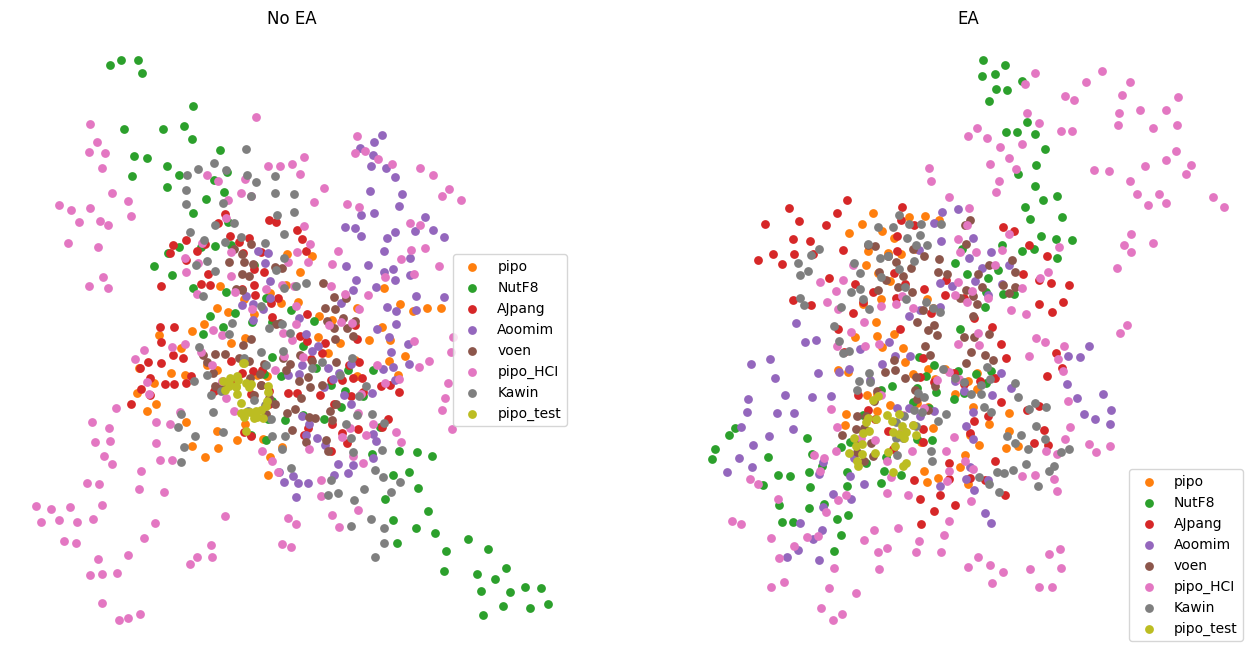

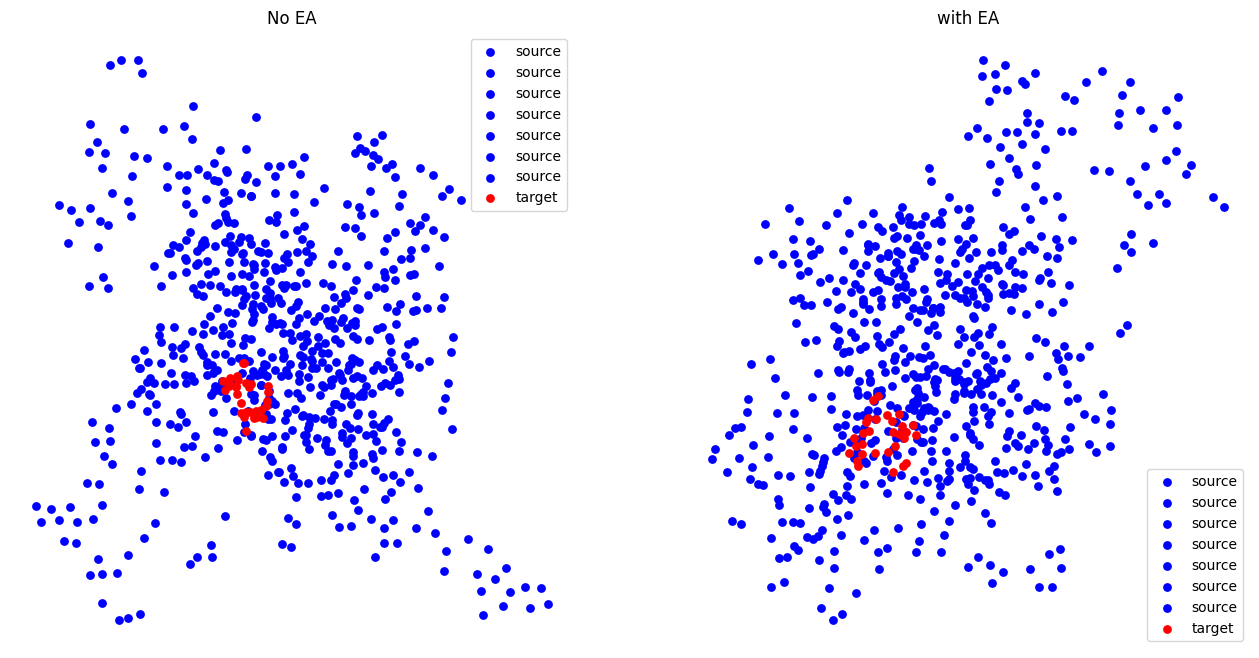

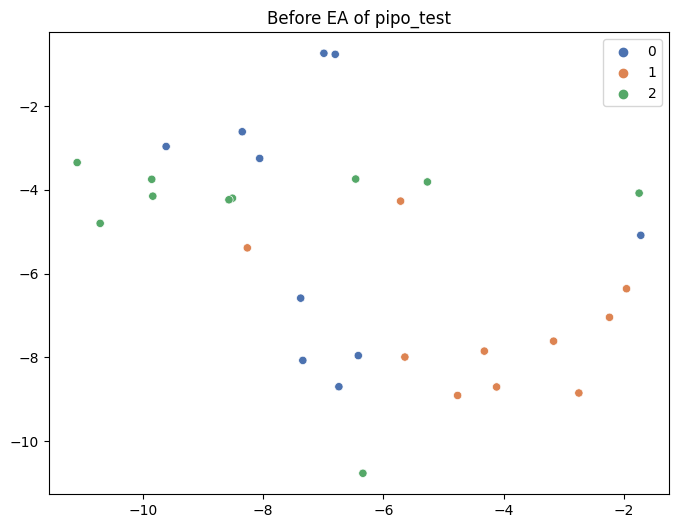

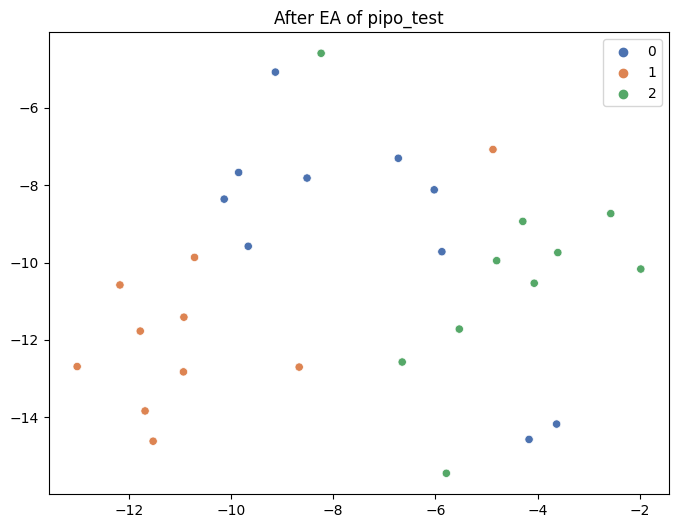

In [54]:
AllBCIClass.TSNE_Plot(CSP2D_Epoch, target_subject= target_data)

In [55]:
AllBCIClass.classifyCSP_LDA(EEG_Epochs, target_subjects= target_data, condition = "noEA")

Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels


Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Classification TRAIN DATA 
              precision    recall  f1-score   support

        Left       0.46      0.53      0.49       222
       Right       0.47      0.49      0.48       220
         Non       0.47      0.37      0.41       222

    accuracy                           0.46       664
   macro avg       0.46      0.46      0.46       664
weighted avg       0.46      0.46      0.46       664

Confusion matrix 
[[118  57  47]
 [ 66 108  46]
 [ 75  65  82]]
Classification TEST DATA 
              precision    recall  f1-score   support

        Left       0.75 

In [56]:
AllBCIClass.classifyCSP_LDA(EEG_Epochs, target_subjects= target_data, condition = "EA")

Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels


Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 5 after 0 projectors applied to 5 channels
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Classification TRAIN DATA 
              precision    recall  f1-score   support

        Left       0.56      0.55      0.56       222
       Right       0.54      0.54      0.54       220
         Non       0.53      0.54      0.54       222

    accuracy                           0.54       664
   macro avg       0.54      0.54      0.54       664
weighted avg       0.54      0.54      0.54       664

Confusion matrix 
[[123  46  53]
 [ 50 118  52]
 [ 48  54 120]]
Classification TEST DATA 
              precision    recall  f1-score   support

        Left       0.89 

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Custom loss function
class CustomLossLL1(tf.keras.losses.Loss):
    def __init__(self, lambda_t, model):
        super().__init__()
        self.lambda_t = lambda_t
        self.cross_entropy = CategoricalCrossentropy()
        self.model = model

    def call(self, y_true, y_pred):
        ce_loss = self.cross_entropy(y_true, y_pred)
        ws = self.get_weights_from_model()
        reg_term = self.regularization_term(ws)
        return ce_loss + self.lambda_t * reg_term

    def get_weights_from_model(self):
        model_weights = []
        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                model_weights.append(layer.get_weights()[0])
        # return tf.concat([tf.reshape(w, [-1]) for w in model_weights], axis=0)
        return model_weights

    def regularization_term(self, ws):
        reg_term = tf.pow(tf.norm(ws, ord='euclidean'),2)
        return reg_term


# Custom training loop
def custom_train_step(model, optimizer, x, y, custom_loss):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True) # Perform a forward pass and compute the predictions
        loss = custom_loss(y, y_pred) # Compute the custom loss
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def train_weight_LL(X_train, y_train, lambd, num_tier=10, learning_rate = 0.01):
    n_classes = np.unique(y_train).size
    y_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)

    lambda_t = lambd  # Regularization parameter

    model = Sequential([
        Dense(n_classes, input_shape=(X_train.shape[1],), activation='softmax')  # Adjust input_shape to match the number of features in X
    ])

    # Compile the model
    optimizer = Adam(learning_rate)
    custom_loss = CustomLossLL1(lambda_t, model)

    # Custom training loop
    epochs = num_tier
    lowest_loss = float('inf')
    best_weights = None
    for epoch in range(epochs):
        loss = custom_train_step(model, optimizer, X_train, y_one_hot, custom_loss)
        loss_value = loss.numpy()
        if loss_value < lowest_loss:
            lowest_loss = loss_value
            best_weights = [layer.get_weights() for layer in model.layers]

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    # best_weights = [layer.get_weights() for layer in model.layers]

    return best_weights, lowest_loss

def build_clf_params(data, target_subjects ,condition):

    for sub in data.keys():
        if (sub  != target_subjects) and  (sub != target_data_0): #Don't apply weight to target subject
            # Where the tranining data is stored
            if condition == "noEA":
                X = data[sub]['Raw_csp']
                y = data[sub]['Raw_csp_label']
                store_ws = 'ws_Raw'

            else:
                X = data[sub]['EA_csp']
                y = data[sub]['EA_csp_label']
                store_ws = 'ws_EA'

            weights, loss = train_weight_LL(X_train=X, y_train=y, lambd= 0.1, num_tier=500, learning_rate= 0.005)
            print("weights of ", str(sub), ": ", weights)
            print("Lowest loss of ", str(sub), ": ", loss)
            data[sub][store_ws] = weights

build_clf_params(CSP2D_Epoch, target_subjects= target_data ,condition = "EA")

Epoch 0, Loss: 2.544753074645996
Epoch 20, Loss: 1.7475236654281616
Epoch 40, Loss: 1.4159947633743286
Epoch 60, Loss: 1.313591480255127
Epoch 80, Loss: 1.3076825141906738
Epoch 100, Loss: 1.3019568920135498
Epoch 120, Loss: 1.2969123125076294
Epoch 140, Loss: 1.2919446229934692
Epoch 160, Loss: 1.2870752811431885
Epoch 180, Loss: 1.2824018001556396
Epoch 200, Loss: 1.2779853343963623
Epoch 220, Loss: 1.273888349533081
Epoch 240, Loss: 1.2701561450958252
Epoch 260, Loss: 1.2668241262435913
Epoch 280, Loss: 1.263917088508606
Epoch 300, Loss: 1.261450171470642
Epoch 320, Loss: 1.2594314813613892
Epoch 340, Loss: 1.2578613758087158
Epoch 360, Loss: 1.2567343711853027
Epoch 380, Loss: 1.2560395002365112
Epoch 400, Loss: 1.2557621002197266
Epoch 420, Loss: 1.2558836936950684
Epoch 440, Loss: 1.2563835382461548
Epoch 460, Loss: 1.2572383880615234
Epoch 480, Loss: 1.2584242820739746
weights of  NutF8 :  [[array([[ 0.20276225, -0.10026018,  0.18535574],
       [ 0.00828651, -0.14058578, -0.108

In [59]:
# First define the kl divergence
def KL_div(P, Q):
    # First convert to np array
    P = np.array(P)
    Q = np.array(Q)
    
    # Then compute their means, datain shape of samples x feat
    mu_P = np.mean(P, axis=0)
    mu_Q = np.mean(Q, axis=0)    

    
    # Compute their covariance
    sigma_P = np.cov(P, rowvar=False)
    sigma_Q = np.cov(Q, rowvar=False)  

    diff = mu_Q - mu_P

    inv_sigma_Q = np.linalg.inv(sigma_Q)
    term1 = np.dot(np.dot(diff.T, inv_sigma_Q), diff)
    
    # Calculate the trace term trace(Sigma_Q^{-1} * Sigma_P)
    term2 = np.trace(np.dot(inv_sigma_Q, sigma_P))
    
    # Calculate the determinant term ln(det(Sigma_P) / det(Sigma_Q))
    det_sigma0 = np.linalg.det(sigma_P)
    det_sigma1 = np.linalg.det(sigma_Q)

    
    epsilon = 1e-6
    term3 = np.log((det_sigma0+epsilon) / (det_sigma1+epsilon))
    
    print(term3)
    
    # Dimensionality of the data
    K = mu_P.shape[0]
    
    # KL divergence
    kl_div = 0.5 * (term1 + term2 - term3 - K)
    
    return kl_div

# Compute kl divergence of target subject to each source subject
def compute_all_kl_div(data, target_subjects , condition):
    '''
    Parameter:
    data, is the whole data containing target and source data
    '''
    kl_div_score = []

    if condition == "noEA":
        target_data = 'Raw_csp'
        label_name = 'Raw_csp_label'

    else:
        target_data = 'EA_csp'
        label_name = 'EA_csp_label'
        
    # cal P from target data
    label_tgt =  data[target_subjects][label_name]
    P_left =  data[target_subjects][target_data][np.where(label_tgt == 0)]
    P_right = data[target_subjects][target_data][np.where(label_tgt == 1)]
    P_non = data[target_subjects][target_data][np.where(label_tgt == 2)]
    P_feet = data[target_subjects][target_data][np.where(label_tgt == 3)]

    tgt_data = target_subjects + "_test"

    #cal Q from each source subject
    for sub in data.keys():
        if (sub != target_subjects) and (sub != tgt_data):
            label_src =  data[sub][label_name]
            Q_left =  data[sub][target_data][np.where(label_src == 0)]
            Q_right = data[sub][target_data][np.where(label_src == 1)]
            Q_non = data[sub][target_data][np.where(label_src == 2)]
            Q_feet = data[sub][target_data][np.where(label_src == 3)]

            kl_left = KL_div(P_left, Q_left)
            kl_right = KL_div(P_right, Q_right)
            kl_non = KL_div(P_non, Q_non)
            kl_feet = KL_div(P_feet, Q_feet)

            # kl_div = (kl_left + kl_right+ kl_non + kl_feet)/4

            kl_div_temp = [kl_left, kl_right, kl_non, kl_feet]

            kl_div_score.append(kl_div_temp)

    data[target_subjects]['kl_div'] = kl_div_score


compute_all_kl_div(CSP2D_Epoch, target_subjects=target_data_0 ,condition = "EA") #target_sub for cal KL is calibrate set

-0.6888230318456046
-0.209656174689765
-0.12627567305914872
nan
0.2198767319847454
0.0716715955165038
0.44061784958477546
nan
0.17754808690423274
0.02822053248755052
0.17236548012922778
nan
-0.05941099656082993
-0.019281757125495194
0.40698382964082336
nan
-0.07126889066461689
-0.24169202959307098
-0.6828733291003181
nan
-0.04534222603639763
-0.22830075320534504
0.3252346532015356
nan


c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\3118780325.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma_P = np.cov(P, rowvar=False)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\pipo_\AppData\Local\Temp\ipykernel_18604\3118780325.py:14: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma_Q

In [60]:
np.array(CSP2D_Epoch[target_data_0]['kl_div'])

array([[9.54445389, 5.41264066, 3.74402458,        nan],
       [6.15061481, 7.40397679, 6.26582331,        nan],
       [3.84258554, 3.38303642, 1.64072197,        nan],
       [0.90188791, 0.93273498, 3.85313984,        nan],
       [1.10315234, 0.47210116, 1.22652729,        nan],
       [3.00593   , 1.10336414, 3.1854824 ,        nan]])

In [65]:
def compute_similarity_weights(data, target_subjects):
    kl = data[target_subjects]['kl_div']
    KL_inv_left = []
    KL_inv_right = []
    KL_inv_non = []
    KL_inv_feet = []

    alpha_s = []
    eps = 0.0001
    
    #equation (9)
    for val in kl:
        if val != 0: 
            KL_inv_left.append(1/((val[0] + eps)**4))
            KL_inv_right.append(1/((val[1] + eps)**4))
            KL_inv_non.append(1/((val[2] + eps)**4))
            KL_inv_feet.append(1/((val[3] + eps)**4))

    print(KL_inv_left)
    print(KL_inv_right)
    print(KL_inv_non)
    print(KL_inv_feet)
    
    for i in range(0,len(KL_inv_left)):
        temp = [KL_inv_left[i]/sum(KL_inv_left), KL_inv_right[i]/sum(KL_inv_right), KL_inv_non[i]/sum(KL_inv_non), KL_inv_feet[i]/sum(KL_inv_feet)]
        alpha_s.append(temp)

    alpha_s = np.array(alpha_s)

    print(np.array(alpha_s[:, ~np.isnan(alpha_s).any(axis=0)]))
                
    data[target_subjects]['alpha_s'] = alpha_s[:, ~np.isnan(alpha_s).any(axis=0)]

compute_similarity_weights(CSP2D_Epoch, target_subjects=target_data_0)

[0.00012049734061636402, 0.0006987110922737266, 0.00458628054532553, 1.510765739344936, 0.6749950248206954, 0.012246916500893257]
[0.0011650139452621068, 0.0003327486811713797, 0.0076334692450813, 1.3206286234996887, 20.11369188483232, 0.6744769380131667]
[0.005088606131808129, 0.0006487236048225593, 0.1379603060704567, 0.004536238011411051, 0.44172248288968197, 0.009710567837481478]
[nan, nan, nan, nan, nan, nan]
[[5.46866753e-05 5.26728322e-05 8.48572086e-03]
 [3.17103983e-04 1.50442967e-05 1.08180655e-03]
 [2.08144374e-03 3.45125864e-04 2.30061557e-01]
 [6.85647958e-01 5.97085126e-02 7.56459599e-03]
 [3.06340651e-01 9.09384065e-01 7.36613051e-01]
 [5.55815708e-03 3.04945797e-02 1.61932690e-02]]


In [66]:
def compute_ETL_and_mu_ws(data, target_subjects, condition):

    mu_ws = 0
    temp_ws = 0

    if condition == "noEA":
        ws_name = 'ws_Raw'
    else:
        ws_name = 'ws_EA'

    alpha_s = np.array(data[target_subjects]['alpha_s'])

    tgt_data = target_subjects + "_test"
    index_count = 0

    for sub in data.keys():
        if (sub != target_subjects) and (sub != tgt_data):
            ws = data[sub][ws_name][0][0]
            # mu_ws += ws @ alpha_s  #equation (10)
            # mu_ws += np.dot(ws, np.transpose(alpha_s))
            mu_ws += ws * alpha_s[index_count]
            index_count += 1

    print(np.array(mu_ws))

    index_count = 0
    for sub in data.keys():
        if (sub != target_subjects) and (sub != tgt_data):
            ws = data[sub][ws_name][0][0]
            # ws_min_mu = np.dot((np.dot(ws,np.transpose(alpha_s)) - mu_ws) , np.transpose((np.dot(ws,np.transpose(alpha_s)) - mu_ws)))
            ws_min_mu = np.dot(((ws * alpha_s[index_count]) - mu_ws), np.transpose((ws * alpha_s[index_count]) - mu_ws))
            temp_ws += ws_min_mu #equation (11)
            index_count += 1

    print(np.array(temp_ws))
    
    # den = np.diag(temp_ws) #get array in diagonal line

    den = temp_ws
    nom = np.trace(temp_ws) #Return the sum along diagonals of the array.
    Sigma_TL = den/nom


    data[target_subjects]['Sigma_TL'] = Sigma_TL
    data[target_subjects]['mu_ws'] = mu_ws

compute_ETL_and_mu_ws(CSP2D_Epoch, target_subjects = target_data_0, condition="EA")

[[ 0.296153   -0.04034146 -0.33062313]
 [-0.40481145 -0.48106873 -0.43322471]
 [ 0.18914028 -0.43233681  0.07789991]
 [-0.29434752 -0.06447521 -0.00405812]
 [ 0.47645038 -0.42511328 -0.01510768]]
[[ 1.23582783  0.3849261   0.19997675 -0.41528751  0.89929095]
 [ 0.3849261   2.96228119  0.48785951  0.7309488   0.24373031]
 [ 0.19997675  0.48785951  1.08127138 -0.11498796  1.30060445]
 [-0.41528751  0.7309488  -0.11498796  0.43636678 -0.5184033 ]
 [ 0.89929095  0.24373031  1.30060445 -0.5184033   2.03681288]]


In [67]:
print(np.array(CSP2D_Epoch[target_data_0]['Sigma_TL']).shape)
print(np.array(CSP2D_Epoch[target_data_0]['mu_ws']).shape)

(5, 5)
(5, 3)


In [71]:
# Custom loss function
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class CustomLossLL2(tf.keras.losses.Loss):
    def __init__(self, lambda_t, model, mu, sigma_TL):
        super().__init__()
        self.lambda_t = lambda_t
        self.cross_entropy = CategoricalCrossentropy()
        self.model = model
        self.mu = tf.convert_to_tensor(mu, dtype=tf.float32)
        self.sigma_TL = tf.convert_to_tensor(sigma_TL, dtype=tf.float32)

    def call(self, y_true, y_pred):
        ce_loss = self.cross_entropy(y_true, y_pred)
        wt = self.get_weights_from_model()
        reg_term = self.regularization_term(wt)

        return ce_loss + (self.lambda_t * tf.linalg.matmul(reg_term, wt))

    def get_weights_from_model(self):
        model_weights = []
        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                model_weights.append(layer.get_weights()[0])
        # return tf.concat([tf.reshape(w, [-1]) for w in model_weights], axis=0)
        return model_weights

    def regularization_term(self, wt):
        diff = wt - self.mu
        reg_term = 0.5 * tf.linalg.matmul(tf.linalg.matmul(tf.linalg.inv(self.sigma_TL), diff[0]), tf.transpose(diff[0]))
        reg_term += 0.5 * tf.math.log(tf.linalg.det(self.sigma_TL))
        return reg_term


# Custom training loop
def custom_train_step(model, optimizer, x, y, custom_loss):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True) # Perform a forward pass and compute the predictions
        loss = custom_loss(y, y_pred) # Compute the custom loss
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def train_weight_LL2(X_train, y_train, lambd, mu, sigma_TL, num_tier=10, learning_rate = 0.01):
    n_classes = np.unique(y_train).size
    y_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)

    lambda_t = lambd  # Regularization parameter

    model = Sequential([
        Dense(n_classes, input_shape=(X_train.shape[1],), activation='softmax')  # Adjust input_shape to match the number of features in X
    ])

    # Compile the model
    optimizer = Adam(learning_rate)
    custom_loss = CustomLossLL2(lambda_t, model, mu, sigma_TL)

    # Custom training loop
    epochs = num_tier
    lowest_loss = float('inf')
    best_weights = None
    best_model = None

    for epoch in range(epochs):
        loss = custom_train_step(model, optimizer, X_train, y_one_hot, custom_loss)
        loss_value = loss.numpy()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if (abs(loss_value) < lowest_loss):
            lowest_loss = abs(loss_value)
            best_model = model
            best_weights = [layer.get_weights() for layer in model.layers]

    return model, best_weights, lowest_loss

def GetConfusionMatrix(model, X_train, X_test, y_train, y_test):
    y_pred_prob = model.predict(X_train)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print("Classification TRAIN DATA \n=======================")
    print(classification_report(y_true= y_train, y_pred=y_pred))
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true= y_train, y_pred=y_pred))

    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    print("Classification TEST DATA \n=======================")
    print(classification_report(y_true=y_test, y_pred=y_pred))
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))


def tgt_test_wLTL(data, target_subjects ,condition):
        tgt_data = target_subjects + "_test"

        if condition == "noEA":
            X = data[target_subjects]['Raw_csp']
            y = data[target_subjects]['Raw_csp_label']
            X_test = data[tgt_data]['Raw_csp']
            y_test = data[tgt_data]['Raw_csp_label']
            store_ws = 'wt_Raw'

        else:
            X = data[target_subjects]['EA_csp']
            y = data[target_subjects]['EA_csp_label']
            X_test = data[tgt_data]['EA_csp']
            y_test = data[tgt_data]['EA_csp_label']
            store_ws = 'wt_EA'

        mu = data[target_subjects]['mu_ws']
        sigma_TL = data[target_subjects]['Sigma_TL']

        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 42, stratify=y)

        X_train = X
        y_train = y
        
        model, weights, loss = train_weight_LL2(X_train=X_train, y_train=y_train, mu =mu, sigma_TL=sigma_TL,  lambd= 0.1, num_tier=2000, learning_rate= 0.05)
        print("weights of ", str(target_subjects), ": ", weights)
        print("loss of ", str(target_subjects), ": ", loss)
        data[target_subjects][store_ws] = weights

        GetConfusionMatrix(model, X_train, X_test, y_train, y_test)

tgt_test_wLTL(CSP2D_Epoch, target_subjects= target_data_0 ,condition = "EA")

Epoch 0, Loss: 2.6064422130584717
Epoch 20, Loss: 2.500509738922119
Epoch 40, Loss: 7.595953464508057
Epoch 60, Loss: 7.421384811401367
Epoch 80, Loss: -4.4998698234558105
Epoch 100, Loss: -31.079036712646484
Epoch 120, Loss: -71.76278686523438
Epoch 140, Loss: -124.58625030517578
Epoch 160, Loss: -187.12750244140625
Epoch 180, Loss: -257.1325988769531
Epoch 200, Loss: -332.6485290527344
Epoch 220, Loss: -412.0608215332031
Epoch 240, Loss: -494.0433044433594
Epoch 260, Loss: -577.5092163085938
Epoch 280, Loss: -661.554443359375
Epoch 300, Loss: -745.4200439453125
Epoch 320, Loss: -828.4635620117188
Epoch 340, Loss: -910.1397705078125
Epoch 360, Loss: -989.9904174804688
Epoch 380, Loss: -1067.6292724609375
Epoch 400, Loss: -1142.744873046875
Epoch 420, Loss: -1215.0853271484375
Epoch 440, Loss: -1284.46240234375
Epoch 460, Loss: -1350.737548828125
Epoch 480, Loss: -1413.822998046875
Epoch 500, Loss: -1473.67236328125
Epoch 520, Loss: -1530.2764892578125
Epoch 540, Loss: -1583.6557617187

In [4]:
import numpy as np

def map_to_sequential(arr):
    # Get the unique values and the indices to reconstruct the array in sequential order
    unique_values, sequential_indices = np.unique(arr, return_inverse=True)
    
    # The array is now mapped to 0, 1, 2, ..., etc.
    return sequential_indices, unique_values

# Example usage
arr = np.array([3, 3, 1, 0, 3, 0, 1, 0, 0, 3, 3, 3, 0, 3, 3, 1, 3, 1, 0, 0])

# Map the array to sequential values
mapped_arr, unique_values = map_to_sequential(arr)

print("Original array:", arr)
print("Mapped to sequential:", mapped_arr)
print("Unique values in original array:", unique_values)

Original array: [3 3 1 2 3 2 1 2 2 3 3 3 2 3 3 1 3 1 2 2]
Mapped to sequential: [2 2 0 1 2 1 0 1 1 2 2 2 1 2 2 0 2 0 1 1]
Unique values in original array: [1 2 3]
